In [ ]:
#users.csv
import requests
import csv

# Replace with your personal access token
GITHUB_TOKEN = 'git-token'
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}
BASE_URL = 'https://api.github.com'

def get_users_in_austin():
    users = []
    page = 1

    while True:
        response = requests.get(f'{BASE_URL}/search/users',
                                headers=HEADERS,
                                params={'q': 'location:Austin followers:>100', 'page': page})
        data = response.json()

        if 'items' not in data or not data['items']:
            break

        for user in data['items']:
            users.append(user['login'])

        page += 1

    return users

def get_user_details(username):
    response = requests.get(f'{BASE_URL}/users/{username}', headers=HEADERS)
    return response.json()

def clean_company(company):
    if company:
        return company.strip().lstrip('@').upper()
    return None

def main():
    users = get_users_in_austin()
    user_details = []

    for user in users:
        details = get_user_details(user)
        user_details.append({
            'login': details.get('login'),
            'name': details.get('name'),
            'company': clean_company(details.get('company')),
            'location': details.get('location'),
            'email': details.get('email'),
            'hireable': details.get('hireable'),
            'bio': details.get('bio'),
            'public_repos': details.get('public_repos'),
            'followers': details.get('followers'),
            'following': details.get('following'),
            'created_at': details.get('created_at'),
        })

    # Write to CSV
    with open('users.csv', 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['login', 'name', 'company', 'location', 'email',
                      'hireable', 'bio', 'public_repos', 'followers',
                      'following', 'created_at']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for user in user_details:
            writer.writerow(user)

if __name__ == '__main__':
    main()


In [ ]:
#more cleaned users.csv
import pandas as pd

# Load the data
users_df = pd.read_csv('users.csv')

# Clean the company names
users_df['company'] = users_df['company'].str.strip()  # Trim whitespace
users_df['company'] = users_df['company'].str.lstrip('@')  # Strip leading '@'
users_df['company'] = users_df['company'].str.upper()  # Convert to uppercase

# Save the cleaned DataFrame back to users.csv
users_df.to_csv('users.csv', index=False)

print("Company names cleaned and saved to users.csv.")


Company names cleaned and saved to users.csv.


In [ ]:
#repositories.csv
import requests
import csv

# Replace with your personal access token
GITHUB_TOKEN = 'git-token'
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}
BASE_URL = 'https://api.github.com'

def read_users_from_csv(file_path):
    users = []
    with open(file_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            users.append(row['login'])
    return users

def get_repositories(username):
    repos = []
    page = 1
    while True:
        response = requests.get(f'{BASE_URL}/users/{username}/repos',
                                headers=HEADERS,
                                params={'sort': 'pushed', 'direction': 'desc', 'per_page': 100, 'page': page})
        data = response.json()

        if not data or len(repos) >= 500:
            break

        for repo in data:
            repos.append({
                'full_name': repo['full_name'],
                'created_at': repo['created_at'],
                'stargazers_count': repo['stargazers_count'],
                'watchers_count': repo['watchers_count'],
                'language': repo['language'],
                'has_projects': repo['has_projects'],
                'has_wiki': repo['has_wiki'],
                'license_name': repo['license']['key'] if repo.get('license') else None  # Safely fetch license key
            })

        page += 1

    return repos[:500]  # Return up to 500 repos

def main():
    users = read_users_from_csv('users.csv')
    all_repos = []

    for user in users:
        repos = get_repositories(user)
        for repo in repos:
            all_repos.append({
                'login': user,
                **repo
            })

    # Write to CSV
    with open('repositories.csv', 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['login', 'full_name', 'created_at',
                      'stargazers_count', 'watchers_count',
                      'language', 'has_projects',
                      'has_wiki', 'license_name']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for repo in all_repos:
            writer.writerow(repo)

if __name__ == '__main__':
    main()


In [ ]:
#Q1 Who are the top 5 users in Austin with the highest number of followers? List their login in order, comma-separated. Users

import pandas as pd

# Load the data
users_df = pd.read_csv('users.csv')

# Sort by followers and get top 5
top_users = users_df.sort_values(by='followers', ascending=False).head(5)

# Extract logins
top_logins = top_users['login'].tolist()
result = ', '.join(top_logins)

print(result)


getify, benawad, steveklabnik, cloudflare, jbogard


In [4]:
#Q2 Who are the 5 earliest registered GitHub users in Austin? List their login in ascending order of created_at, comma-separated.

import pandas as pd

# Load the data
users_df = pd.read_csv('users.csv')

# Convert created_at to datetime
users_df['created_at'] = pd.to_datetime(users_df['created_at'])

# Sort by created_at and get the earliest 5 users
earliest_users = users_df.sort_values(by='created_at').head(5)

# Extract logins
earliest_logins = earliest_users['login'].tolist()
result = ', '.join(earliest_logins)

print(result)

jnewland, joshknowles, hassox, dan, damon


In [5]:
#Q3 What are the 3 most popular license among these users? Ignore missing licenses. List the license_name in order, comma-separated.
import pandas as pd

# Load the data
repositories_df = pd.read_csv('repositories.csv')

# Filter out missing license names
repositories_df = repositories_df[repositories_df['license_name'].notna()]

# Count occurrences of each license
license_counts = repositories_df['license_name'].value_counts()

# Get the top 3 licenses
top_licenses = license_counts.head(3).index.tolist()

# Join the license names in order
result = ', '.join(top_licenses)

print(result)


mit, apache-2.0, other


In [6]:
#Q4 Which company do the majority of these developers work at?
import pandas as pd

# Load the data
users_df = pd.read_csv('users.csv')

# Count occurrences of each company
company_counts = users_df['company'].value_counts()

# Get the company with the highest count
most_common_company = company_counts.idxmax()
most_common_count = company_counts.max()

print(f"The majority of developers work at: {most_common_company} with {most_common_count} developers.")


The majority of developers work at: GOOGLE with 9 developers.


In [7]:
#Q5
import pandas as pd

# Load the data
repositories_df = pd.read_csv('repositories.csv')

# Count occurrences of each programming language, ignoring missing values
language_counts = repositories_df['language'].value_counts()

# Get the most popular programming language
most_popular_language = language_counts.idxmax()
most_popular_count = language_counts.max()

print(f"The most popular programming language is: {most_popular_language} with {most_popular_count} repositories.")


The most popular programming language is: JavaScript with 9009 repositories.


In [8]:
#Q6 Which programming language is the second most popular among users who joined after 2020?
import pandas as pd

# Load the data
users_df = pd.read_csv('users.csv')
repositories_df = pd.read_csv('repositories.csv')

# Convert created_at to datetime and filter users who joined after 2020
users_df['created_at'] = pd.to_datetime(users_df['created_at'])
recent_users = users_df[users_df['created_at'] > '2020-01-01']

# Get the logins of recent users
recent_user_logins = recent_users['login'].tolist()

# Filter repositories by these users
recent_repositories = repositories_df[repositories_df['login'].isin(recent_user_logins)]

# Count occurrences of each programming language
language_counts = recent_repositories['language'].value_counts()

# Get the second most popular programming language
second_most_popular_language = language_counts.nlargest(2).index[1]
second_most_popular_count = language_counts.nlargest(2).values[1]

print(f"The second most popular programming language among users who joined after 2020 is: {second_most_popular_language} with {second_most_popular_count} repositories.")


The second most popular programming language among users who joined after 2020 is: HTML with 75 repositories.


In [9]:
#Q7. Which language has the highest average number of stars per repository?
import pandas as pd

# Load the data
repositories_df = pd.read_csv('repositories.csv')

# Group by programming language and calculate the average stars
average_stars = repositories_df.groupby('language')['stargazers_count'].mean()

# Identify the language with the highest average stars
highest_average_language = average_stars.idxmax()
highest_average_value = average_stars.max()

print(f"The programming language with the highest average number of stars per repository is: {highest_average_language} with an average of {highest_average_value:.2f} stars.")


The programming language with the highest average number of stars per repository is: Fennel with an average of 2449.00 stars.


In [10]:
#Q8. Let's define leader_strength as followers / (1 + following). Who are the top 5 in terms of leader_strength? List their login in order, comma-separated.
import pandas as pd

# Load the data
users_df = pd.read_csv('users.csv')

# Calculate leader_strength
users_df['leader_strength'] = users_df['followers'] / (1 + users_df['following'])

# Sort by leader_strength and get the top 5
top_leaders = users_df.sort_values(by='leader_strength', ascending=False).head(5)

# Extract logins
top_logins = top_leaders['login'].tolist()
result = ', '.join(top_logins)

print(result)


getify, cloudflare, benawad, oracle, ContinuumIO


In [11]:
#Q9. What is the correlation between the number of followers and the number of public repositories among users in Austin?
import pandas as pd

# Load the data
users_df = pd.read_csv('users.csv')

# Calculate the correlation between followers and public repositories
correlation = users_df['followers'].corr(users_df['public_repos'])

print(f"The correlation between the number of followers and the number of public repositories is: {correlation:.4f}")


The correlation between the number of followers and the number of public repositories is: 0.1506


In [12]:

import pandas as pd
import statsmodels.api as sm

# Load the data
users_df = pd.read_csv('users.csv')

# Define the independent variable (X) and dependent variable (Y)
X = users_df['public_repos']
Y = users_df['followers']

# Add a constant to the independent variable (for the intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Get the summary of the regression results
summary = model.summary()

# Extract the coefficient for public_repos
additional_followers_per_repo = model.params['public_repos']

print(f"Regression Results:\n{summary}")
print(f"Estimated additional followers per additional public repository: {additional_followers_per_repo:.3f}")


Regression Results:
                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     10.91
Date:                Sun, 03 Nov 2024   Prob (F-statistic):            0.00103
Time:                        10:03:21   Log-Likelihood:                -4356.7
No. Observations:                 472   AIC:                             8717.
Df Residuals:                     470   BIC:                             8726.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          190.4130    1

       public_repos     followers
count    472.000000    472.000000
mean      88.351695    552.086864
std       91.979824   2499.862299
min        0.000000    101.000000
25%       29.000000    130.000000
50%       59.500000    190.000000
75%      118.250000    325.000000
max      832.000000  43949.000000


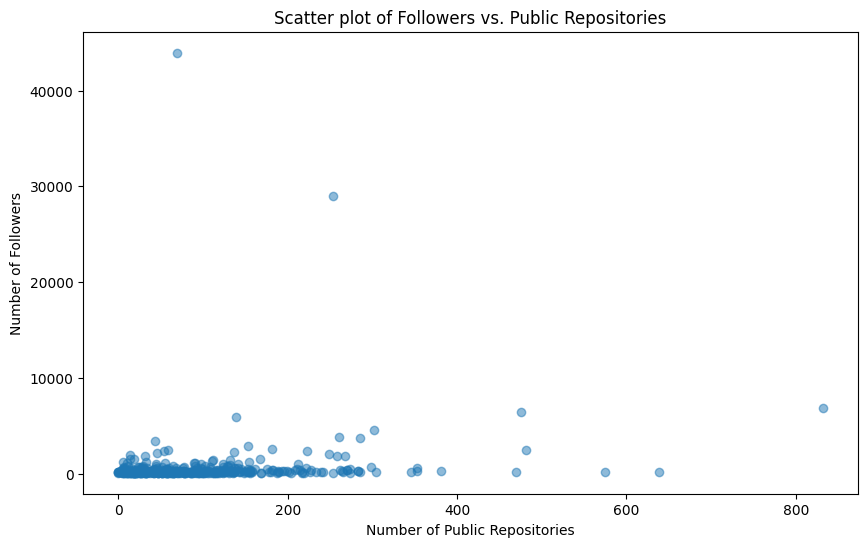

Estimated increase in followers per additional repository: 4.094


In [13]:
#Q10. Does creating more repos help users get more followers? Using regression, estimate how many additional followers a user gets per additional public repository.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your data
repos_df = pd.read_csv('repositories.csv')
users_df = pd.read_csv('users.csv')

# Check summary statistics for context
print(users_df[['public_repos', 'followers']].describe())

# Plot the data to visually inspect for outliers
plt.figure(figsize=(10, 6))
plt.scatter(users_df['public_repos'], users_df['followers'], alpha=0.5)
plt.xlabel("Number of Public Repositories")
plt.ylabel("Number of Followers")
plt.title("Scatter plot of Followers vs. Public Repositories")
plt.show()

# Simple linear regression
X = users_df[['public_repos']].values  # Independent variable
y = users_df['followers'].values       # Dependent variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Retrieve and print the slope (effect of public_repos on followers)
slope = round(model.coef_[0], 3)
print("Estimated increase in followers per additional repository:", slope)


In [14]:
#Q11. Do people typically enable projects and wikis together? What is the correlation between a repo having projects enabled and having wiki enabled?
import pandas as pd

# Load the data
repositories_df = pd.read_csv('repositories.csv')


# Calculate the correlation directly
correlation = repositories_df['has_projects'].astype(int).corr(repositories_df['has_wiki'].astype(int))

print(f"The correlation between having projects enabled and having a wiki enabled is: {correlation:.4f}")


The correlation between having projects enabled and having a wiki enabled is: 0.2742


In [23]:
#Q12 Do hireable users follow more people than those who are not hireable?
import pandas as pd

# Load the users data from the CSV file
users_df = pd.read_csv('users.csv')

# Filter hireable and non-hireable users
hireable_users = users_df[users_df['hireable'] == True]
non_hireable_users = users_df[users_df['hireable'].isna() | (users_df['hireable'] == False)]

# Calculate average following for both groups
average_hireable_following = hireable_users['following'].mean()
average_non_hireable_following = non_hireable_users['following'].mean()

# Calculate the difference
difference = average_hireable_following - average_non_hireable_following

# Print the result rounded to three decimal places
print(f'Difference in average following (hireable - non-hireable): {difference:.4f}')


Difference in average following (hireable - non-hireable): 110.2262


In [21]:
#Q13. Some developers write long bios. Does that help them get more followers? What's the impact of the length of their bio (in Unicode words, split by whitespace) with followers? (Ignore people without bios)
import pandas as pd
import statsmodels.api as sm

# Load the users data from the CSV file
users_df = pd.read_csv('users.csv')

# Filter out users without bios
users_with_bios = users_df[users_df['bio'].notna()]

# Calculate the length of the bio in words
#users_with_bios['bio_word_count'] = users_with_bios['bio'].str.split(" ").str.len()

users_with_bios['bio_word_count'] = users_with_bios['bio'].apply(lambda x: len(x.split()))


# Prepare the data for regression
X = users_with_bios['bio_word_count']  # Independent variable
y = users_with_bios['followers']        # Dependent variable

# Add a constant to the independent variable for the regression
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the regression slope (coefficient for bio_word_count)
slope = model.params['bio_word_count']

# Print the slope rounded to three decimal places
print(f'Regression slope of followers on bio word count: {slope:.3f}')


Regression slope of followers on bio word count: 8.276


<ipython-input-21-0d29c74c7506>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_bios['bio_word_count'] = users_with_bios['bio'].apply(lambda x: len(x.split()))


In [17]:
#Q14. Who created the most repositories on weekends (UTC)? List the top 5 users' login in order, comma-separated
import pandas as pd

# Load the repositories data from the CSV file
repos_df = pd.read_csv('repositories.csv')

# Convert the created_at column to datetime
repos_df['created_at'] = pd.to_datetime(repos_df['created_at'])

# Filter for weekend days (Saturday: 5, Sunday: 6)
weekend_repos = repos_df[repos_df['created_at'].dt.dayofweek.isin([5, 6])]

# Count the number of repositories created by each user
top_users = weekend_repos['login'].value_counts().head(5)

# Get the top 5 users' logins in order
top_users_logins = ', '.join(top_users.index)

# Print the result
print(f'Top 5 users who created the most repositories on weekends: {top_users_logins}')


Top 5 users who created the most repositories on weekends: FellowTraveler, realityexpander, OR13, PaulBratslavsky, skeptycal


In [20]:
#Q15. Do people who are hireable share their email addresses more often?
import pandas as pd

# Load the users data from the CSV file
users_df = pd.read_csv('users.csv')

# Total number of users
total_users = len(users_df)

# Filter hireable and non-hireable users
hireable_users = users_df[users_df['hireable'] == True]
non_hireable_users = users_df[users_df['hireable'].isna() | (users_df['hireable'] == False)]

# Calculate the fraction of users with email in both groups
fraction_hireable_with_email = hireable_users['email'].notna().mean()
fraction_non_hireable_with_email = non_hireable_users['email'].notna().mean()

# Calculate the difference
difference = fraction_hireable_with_email - fraction_non_hireable_with_email

# Print the result rounded to three decimal places
print(f'Difference in fraction of users with email: {difference:.3f}')


Difference in fraction of users with email: 0.031


In [19]:
#Q16. Let's assume that the last word in a user's name is their surname (ignore missing names, trim and split by whitespace.) What's the most common surname? (If there's a tie, list them all, comma-separated, alphabetically)
import pandas as pd

# Load the users data from the CSV file
users_df = pd.read_csv('users.csv')

# Filter out users without names
valid_users = users_df[users_df['name'].notna()]

# Extract surnames (last word in name)
valid_users['surname'] = valid_users['name'].str.strip().str.split().str[-1]

# Count occurrences of each surname
surname_counts = valid_users['surname'].value_counts()

# Find the most common surname(s)
max_count = surname_counts.max()
most_common_surnames = surname_counts[surname_counts == max_count].index.tolist()

# Sort surnames alphabetically
most_common_surnames.sort()

# Count users with the most common surname
number_of_users = max_count

# Print results
most_common_surnames_str = ', '.join(most_common_surnames)
print(f'Most common surname(s): {most_common_surnames_str}')
print(f'Number of users with the most common surname: {number_of_users}')


Most common surname(s): Moore, Smith
Number of users with the most common surname: 3


<ipython-input-19-dc0f22873520>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_users['surname'] = valid_users['name'].str.strip().str.split().str[-1]
